# Rotation strategy in SPY and TLT

(strategy #5 from here: https://www.quantifiedstrategies.com/swing-trading-strategies/)

**Trading rules:**
- Every month rank SPY and TLT from the month’s close to the previous month’s close.
- On the next day’s open, buy the ETF with the best performance of the last month. If you are already long the one with the best performance, keep holding.
- Rinse and repeat.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
%config InlineBackend.figure_format = 'retina'
sns.set_style('darkgrid')

## Download data

In [3]:
import yfinance as yf
start = '2003-01-01'
end = '2023-12-31'

s1 = 'SPY'
s2 = 'TLT'

In [4]:
s1_prices = yf.download(s1, start=start, end=end)
s2_prices = yf.download(s2, start=start, end=end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
s1_prices.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-01-02,88.849998,91.300003,88.540001,91.070000,60.547806,44516300
2003-01-03,90.910004,91.379997,90.500000,91.349998,60.733963,32222600
2003-01-06,91.239998,93.489998,91.169998,92.959999,61.804348,40984500
2003-01-07,92.900002,93.370003,92.199997,92.730003,61.651417,38640400
2003-01-08,92.199997,92.400002,91.050003,91.389999,60.760555,38702200


In [6]:
s2_prices.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-01-02,87.699997,87.900002,86.209999,86.279999,42.003681,192100
2003-01-03,86.150002,86.540001,85.830002,86.480003,42.101067,311200
2003-01-06,86.169998,86.290001,85.809998,86.250000,41.989086,35600
2003-01-07,86.190002,86.750000,86.169998,86.559998,42.140007,69800
2003-01-08,86.879997,87.139999,86.779999,86.989998,42.349361,160100


## estimate adjusted open prices

How to estimate adjusted open price: https://quant.stackexchange.com/questions/33603/if-i-have-adj-close-and-close-how-to-convert-open-to-adj-open

In [7]:
# estimated adjusted open prices
s1_prices['Adj Open'] = s1_prices['Open'] * s1_prices['Adj Close'] / s1_prices['Close']
s2_prices['Adj Open'] = s2_prices['Open'] * s2_prices['Adj Close'] / s2_prices['Close']

## resample daily to monthly

In [8]:
from collections import OrderedDict

s1_prices_m = s1_prices.resample('1M').agg(
    OrderedDict([
        ('Adj Open', 'first'),
        ('Adj Close', 'last')
    ])
)

s2_prices_m = s2_prices.resample('1M').agg(
    OrderedDict([
        ('Adj Open', 'first'),
        ('Adj Close', 'last')
    ])
)

In [9]:
s1_prices_m.head()

,Adj Open,Adj Close
Date,,
2003-01-31,59.071840,57.216930
2003-02-28,57.270106,56.445656
2003-03-31,56.685016,56.566425
2003-04-30,56.906893,61.352650
2003-05-31,61.359292,64.716995


In [10]:
s2_prices_m.head()

,Adj Open,Adj Close
Date,,
2003-01-31,42.694979,42.870224
2003-02-28,42.830181,44.198090
2003-03-31,44.134366,43.594936
2003-04-30,43.534842,44.051945
2003-05-31,44.162363,46.835835


## calculate returns
monthly return = month_close / month_open - 1

In [11]:
returns_m = pd.DataFrame(columns=[s1, s2])
returns_m[s1] = s1_prices_m['Adj Close'] / s1_prices_m['Adj Open'] - 1
returns_m[s2] = s2_prices_m['Adj Close'] / s2_prices_m['Adj Open'] - 1

In [12]:
returns_m.head()

,SPY,TLT
Date,,
2003-01-31,-0.031401,0.004105
2003-02-28,-0.014396,0.031938
2003-03-31,-0.002092,-0.012222
2003-04-30,0.078123,0.011878
2003-05-31,0.054722,0.060537


## calculate positions and backtest

In [13]:
positions = pd.DataFrame(index=returns_m.index, columns=returns_m.columns)
positions[s1] = (returns_m[s1] > returns_m[s2]).astype(int)
positions[s2] = (returns_m[s2] > returns_m[s1]).astype(int)

In [14]:
positions.head()

,SPY,TLT
Date,,
2003-01-31,0,1
2003-02-28,0,1
2003-03-31,1,0
2003-04-30,1,0
2003-05-31,0,1


In [15]:
algo_ret = (positions.shift() * returns_m).sum(axis=1)

In [16]:
# cumulative returns
algo_cumret = (1 + algo_ret).cumprod()
s1_cumret = (1 + returns_m[s1]).cumprod()
s2_cumret = (1 + returns_m[s2]).cumprod()

In [17]:
# make sure that each series start from 1
algo_cumret /= algo_cumret[0]
s1_cumret /= s1_cumret[0]
s2_cumret /= s2_cumret[0]

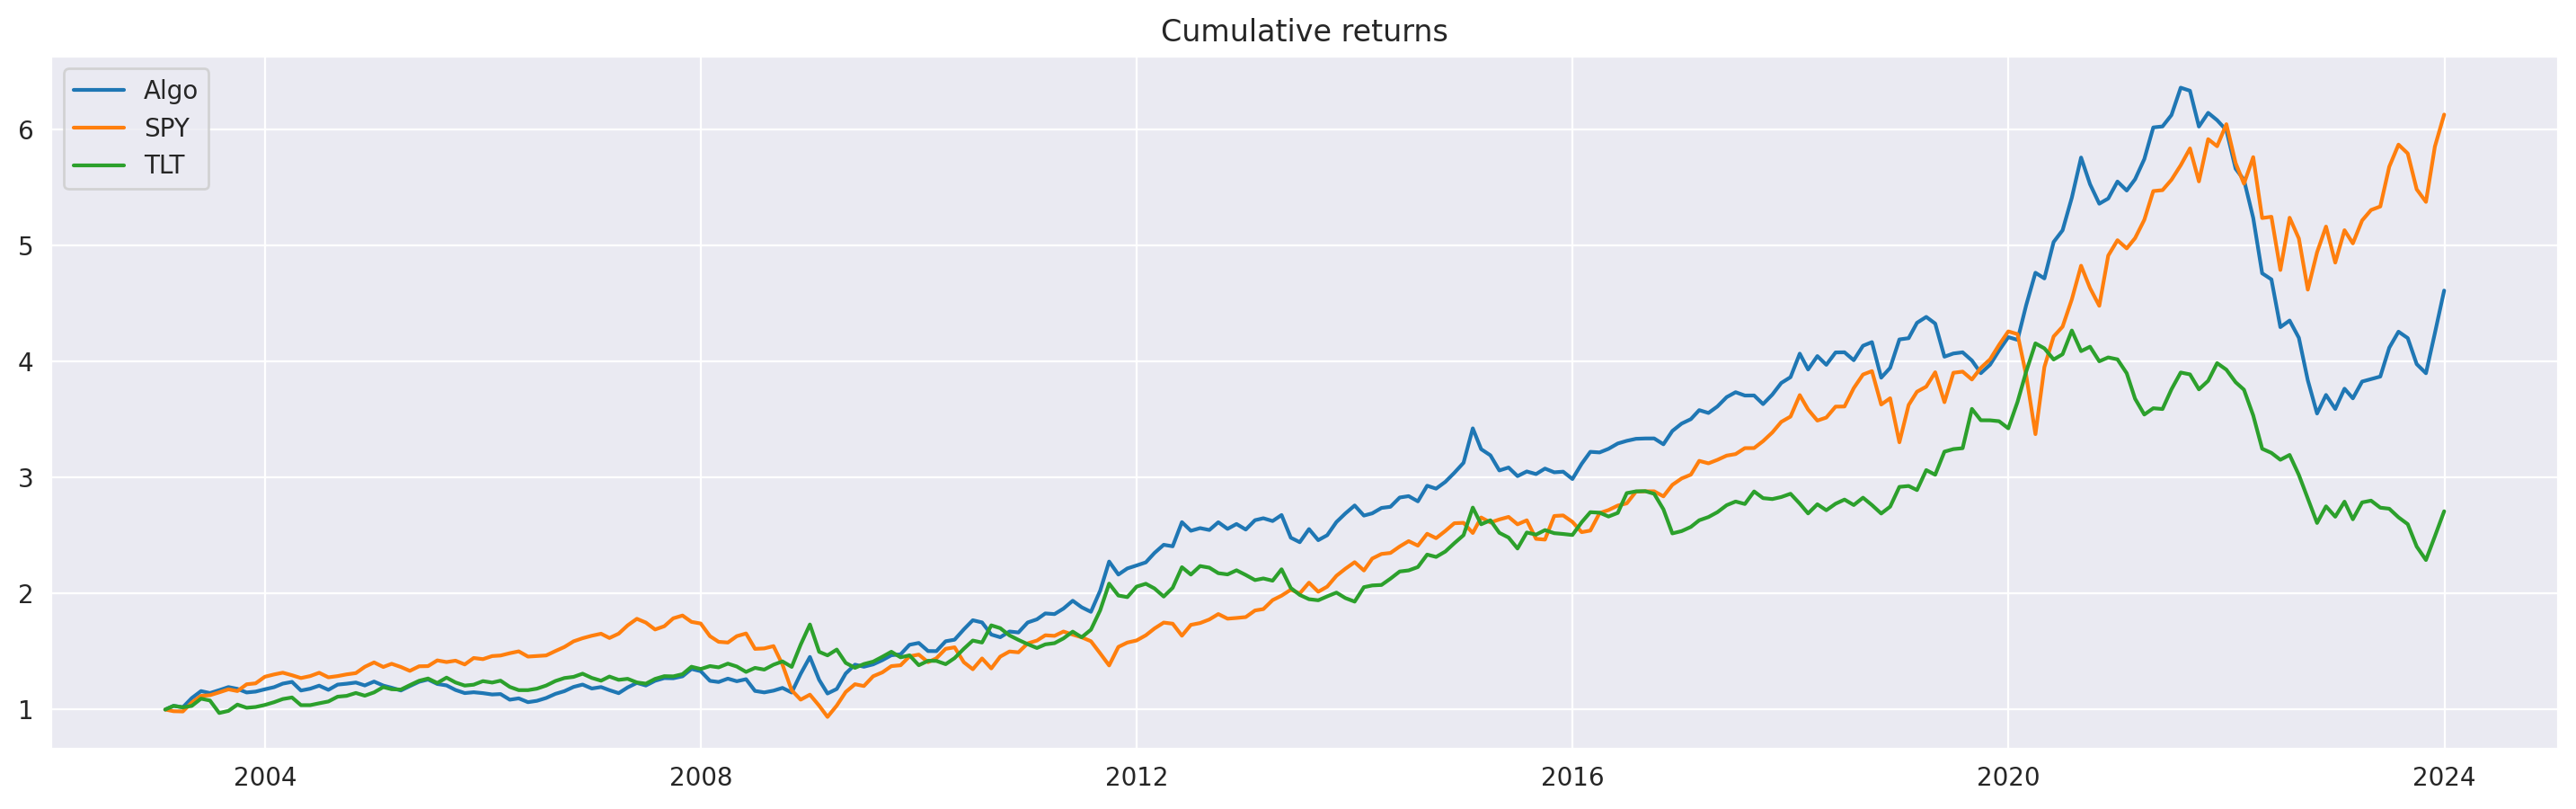

In [18]:
plt.figure(figsize=(18,5))
plt.plot(algo_cumret, label='Algo')
plt.plot(s1_cumret, label=s1)
plt.plot(s2_cumret, label=s2)
plt.title('Cumulative returns')
plt.legend()

## calculate performance metrics

In [19]:
def calculate_metrics(cumret, num_periods=12):
    '''
    calculate performance metrics from cumulative returns
    
    cumret: cumulative returns
    num_periods: number of periods in a year (e.g. 252 if cumret is at daily resolution)
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(num_periods/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    rets.iloc[0] = 0
    sharpe = np.sqrt(num_periods) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, maxDD, maxDDD

In [20]:
results_df = pd.DataFrame(index=['Algo',s1,s2], 
                          columns=['Total return', 'APR', 'Sharpe', 'MaxDD', 'MaxDDD'])
results_df.loc['Algo'] = calculate_metrics(algo_cumret)
results_df.loc[s1] = calculate_metrics(s1_cumret)
results_df.loc[s2] = calculate_metrics(s2_cumret)

In [21]:
results_df

,Total return,APR,Sharpe,MaxDD,MaxDDD
Algo,3.612102,0.075509,0.62066,-0.441542,29.0
SPY,5.129102,0.090172,0.658117,-0.482728,58.0
TLT,1.709343,0.048607,0.424968,-0.463597,41.0


In [22]:
# find peak date
np.argmax(algo_cumret)

222

In [23]:
algo_cumret[[222]]

Date
2021-07-31    6.360608
Freq: M, dtype: float64

In [24]:
results_df.loc['Algo (until 07.2021)'] = calculate_metrics(algo_cumret[:223])
results_df.loc['SPY (until 07.2021)'] = calculate_metrics(s1_cumret[:223])
results_df.loc['TLT (until 07.2021)'] = calculate_metrics(s2_cumret[:223])

In [25]:
results_df

,Total return,APR,Sharpe,MaxDD,MaxDDD
Algo,3.612102,0.075509,0.62066,-0.441542,29.0
SPY,5.129102,0.090172,0.658117,-0.482728,58.0
TLT,1.709343,0.048607,0.424968,-0.463597,41.0
Algo (until 07.2021),5.360608,0.104683,0.868661,-0.216721,25.0
SPY (until 07.2021),4.691935,0.0981,0.728587,-0.482728,58.0
TLT (until 07.2021),2.905407,0.076065,0.643667,-0.21555,31.0


## analyzing the strategy

signal = sign of the difference of monthly return of s1 and monthly return of s2

- if it is positive - all capital is invested in SPY
- if it is negative - all capital is invested in TLT

According to these rules we are betting on the fact that the signal will be the same the next month. If it is positive now, it's going to be positive next month. Similarly, if it is negative now, it will be negative the next month.

In [26]:
signal = np.sign(returns_m[s1] - returns_m[s2])

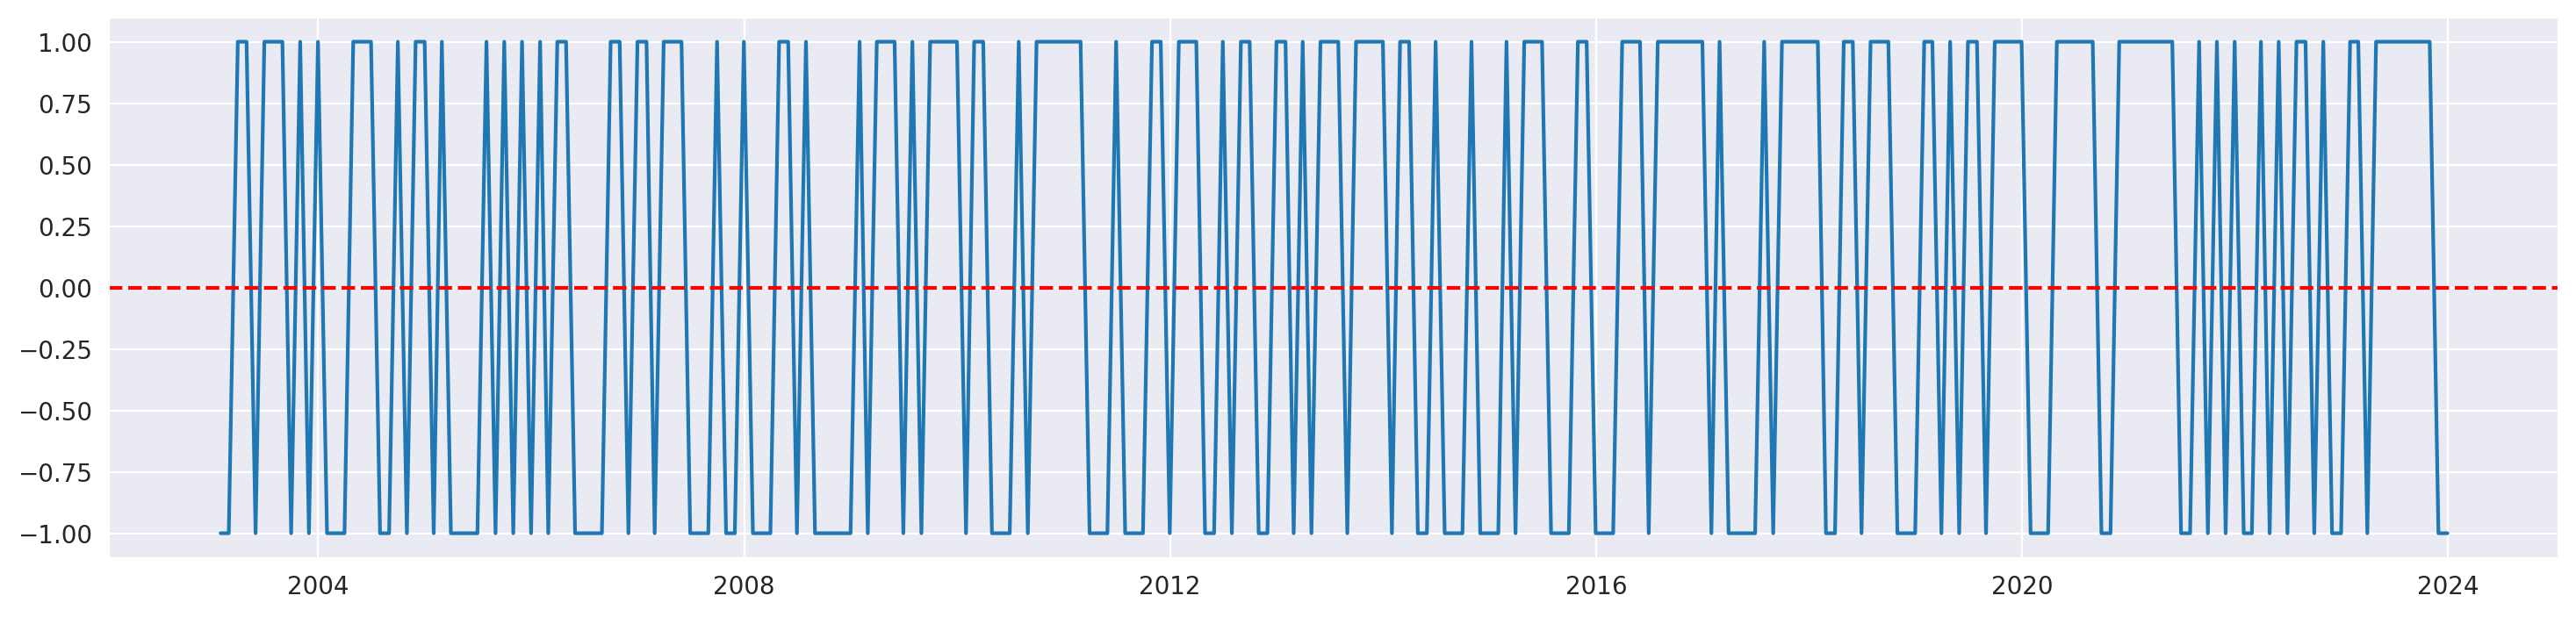

In [27]:
plt.figure(figsize=(18,4))
plt.plot(signal)
plt.axhline(0, linestyle='dashed', color='r')

The plot above doesn't look like it tends to stay the same. Let's look at ACF and PACF plots to check if there is any autocorrelation.

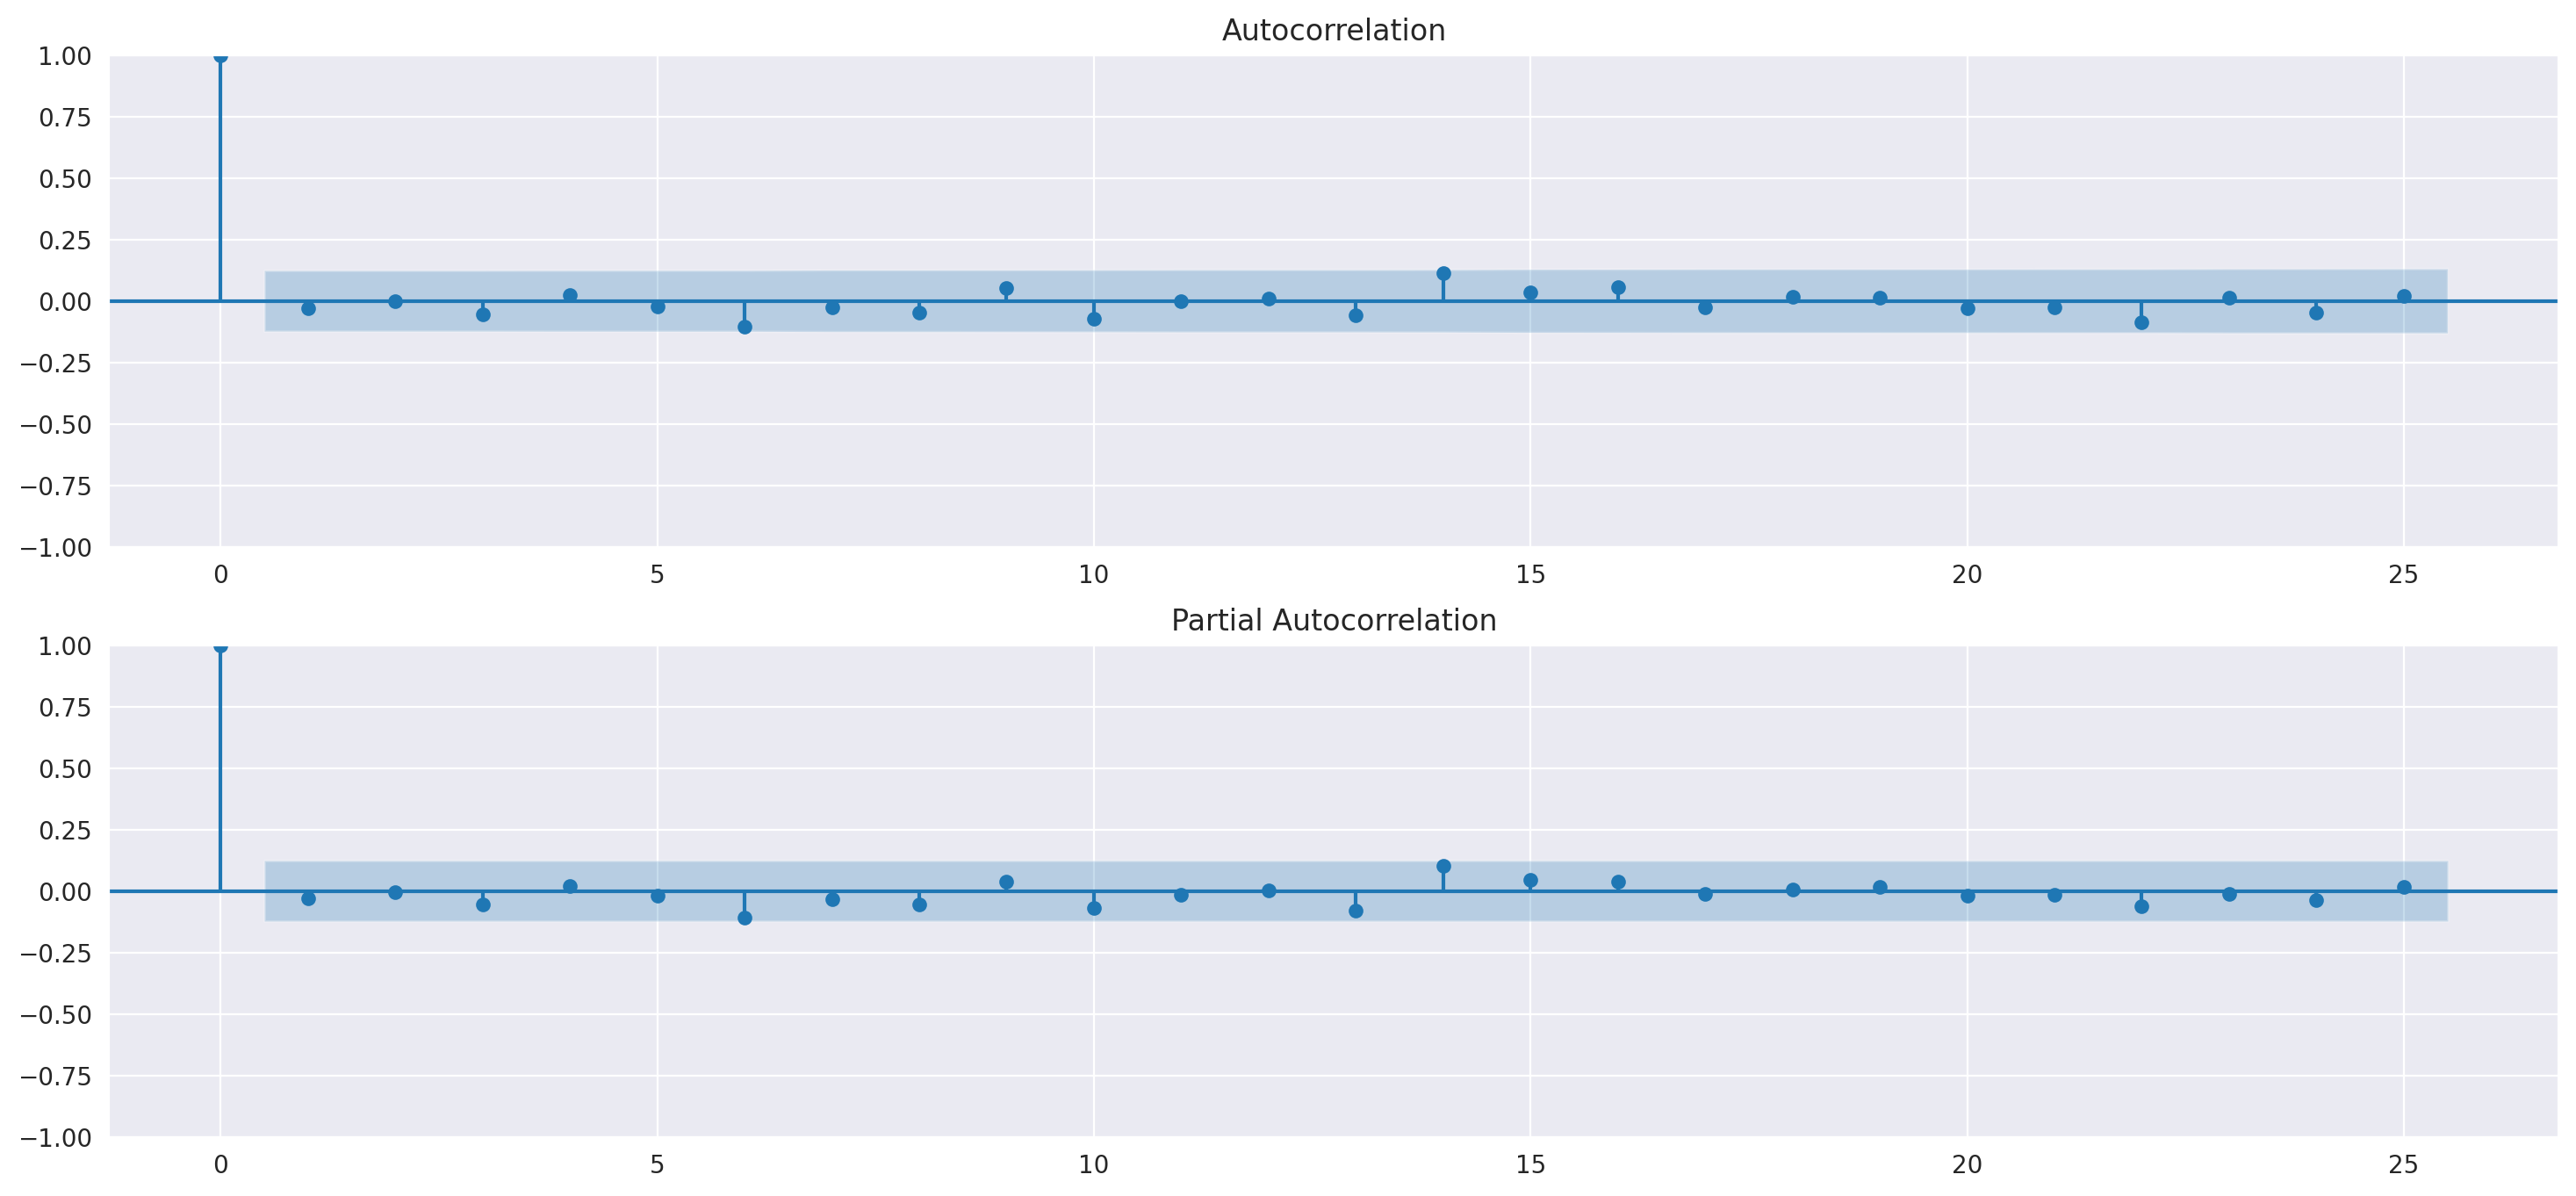

In [28]:
import statsmodels.api as sm

fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(signal, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(signal, ax=ax2)

There is no statistically significant autocorrelations. Let's calculate how many times it changes from one month to the next and the number and length of periods where it doesn't change.

In [29]:
# number of changes
np.unique(signal.values[:-1] * signal.values[1:], return_counts=True)

(array([-1.,  1.]), array([128, 123]))

It changes on 128 of 252 months and stays the same on 123 of 252 months. This means that our signal is wrong on 128 of 252 months. Our hit rate is 123/252 = 48.8%

In [30]:
# prepare confusuion matrix
from sklearn.metrics import confusion_matrix

# prepare data
y_true = signal.iloc[1:].values
y_pred = signal.shift().iloc[1:].values

confusion_matrix(y_true, y_pred)

array([[49, 64],
       [64, 74]])

<Axes: xlabel='Predicted', ylabel='Actual'>

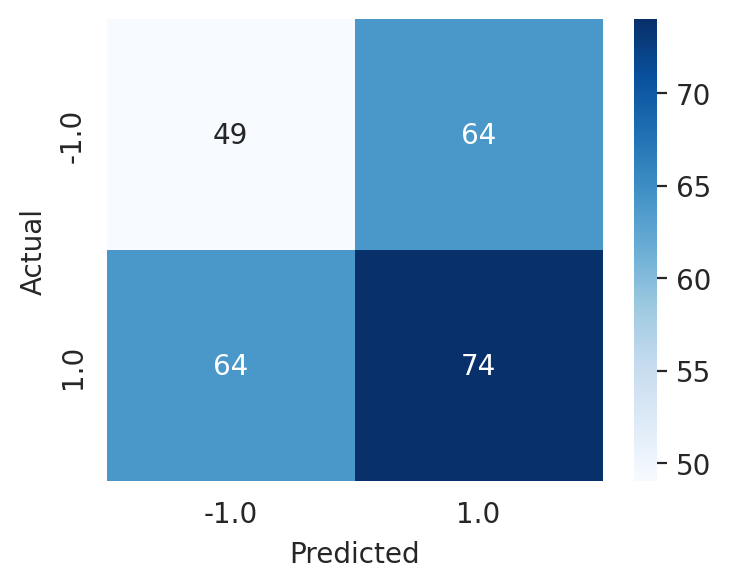

In [31]:
# https://www.kaggle.com/code/agungor2/various-confusion-matrix-plots
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (4,3))
sns.heatmap(df_cm, cmap="Blues", annot=True)# font size

- 49 true negatives
- 74 true positives
- 64 false negatives
- 64 false positive

In [32]:
49/(49+64) # fraction of correct negative predictions

0.4336283185840708

In [33]:
74/(74+64) # fraction of correct positive predictions

0.5362318840579711

In [34]:
from sklearn.metrics import precision_score

precision_score(y_true, y_pred)

0.5362318840579711

In [35]:
from sklearn.metrics import recall_score

recall_score(y_true, y_pred)

0.5362318840579711

In [36]:
p_scores = []
r_scores = []

for _ in range(1000):
    # generate random sample
    rs = np.random.choice([-1,1], size=len(y_true))

    # calculate precision and recall scores
    p_score = precision_score(y_true, rs)
    r_score = recall_score(y_true, rs)

    # save results
    p_scores.append(p_score)
    r_scores.append(r_score)

Text(0, 0.5, 'frequency')

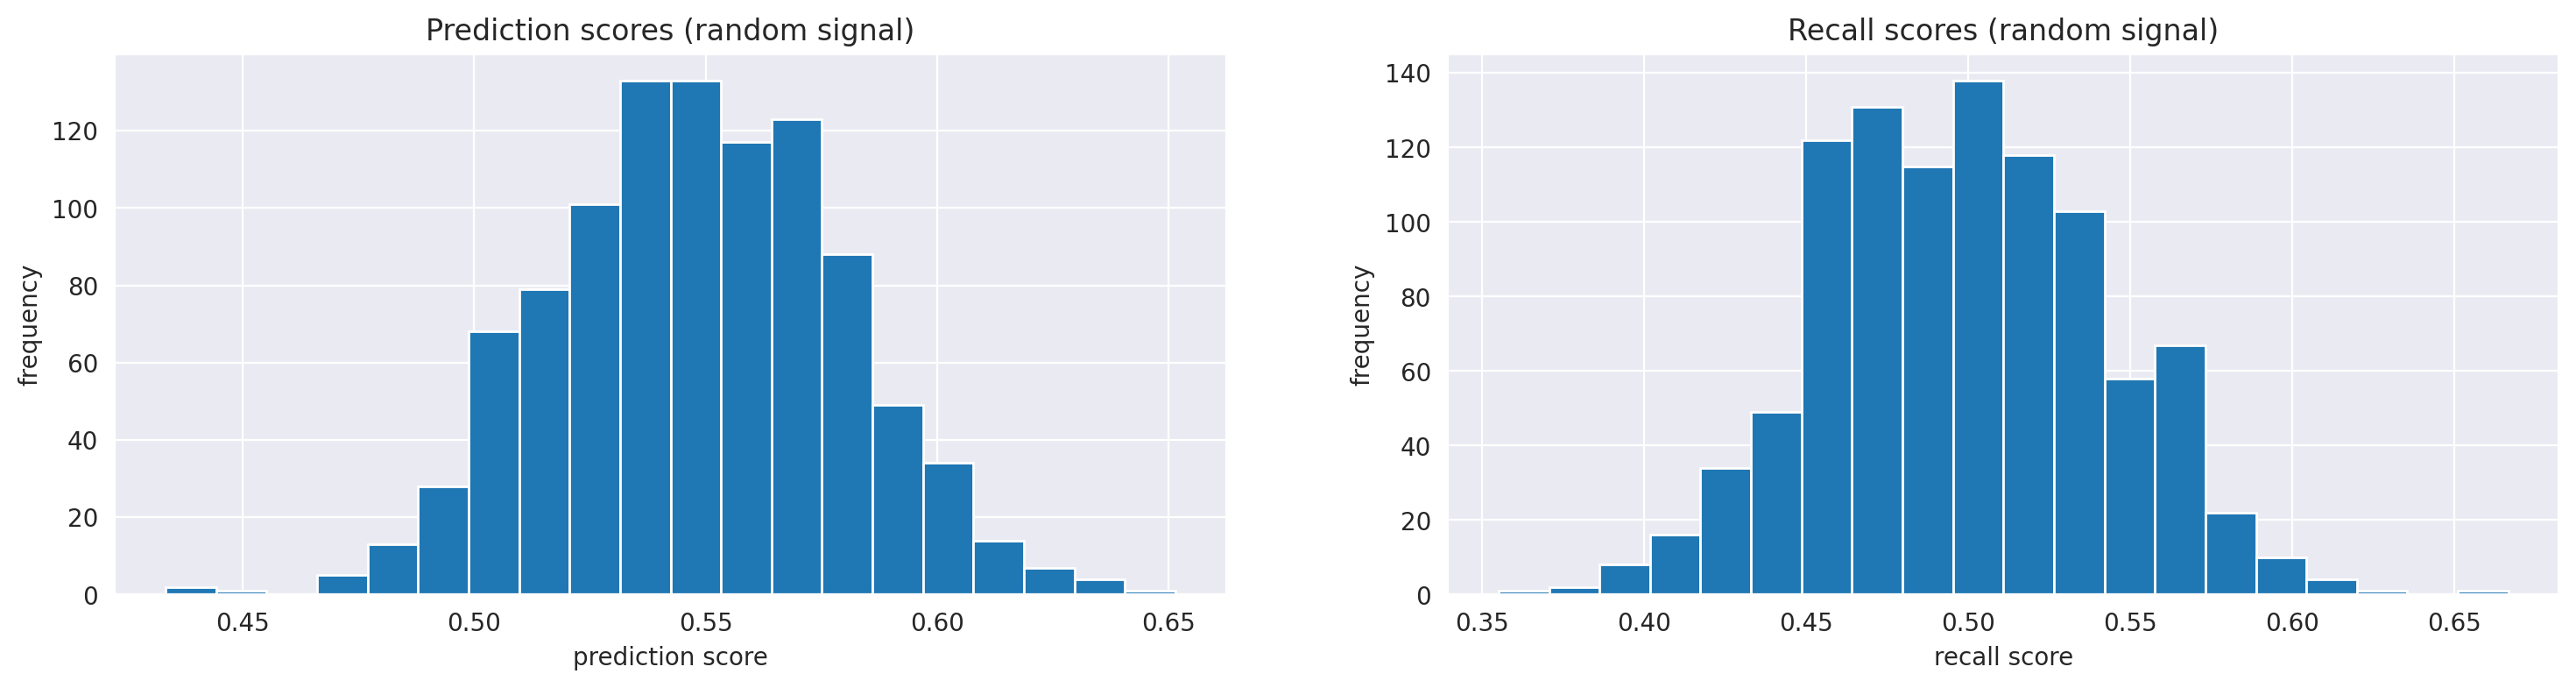

In [37]:
fig,axs = plt.subplots(1,2,figsize=(18,4))
axs[0].hist(p_scores, bins=20)
axs[0].set_title('Prediction scores (random signal)')
axs[0].set_xlabel('prediction score')
axs[0].set_ylabel('frequency')
axs[1].hist(r_scores, bins=20)
axs[1].set_title('Recall scores (random signal)')
axs[1].set_xlabel('recall score')
axs[1].set_ylabel('frequency')

It doesn't look like our signal is doing a good. Maybe it works better for larger market moves and helps us avoid big losses during market turmoil? We need to compare the distributions of returns when the signal is right vs when it is wrong.

In [38]:
ret_signal_correct = algo_ret.iloc[np.where(y_true == y_pred)] # signal's prediction is correct
ret_signal_incorrect = algo_ret.iloc[np.where(y_true != y_pred)] # signal's prediction is incorrect

In [39]:
pd.concat([ret_signal_correct.describe().rename('correct'), ret_signal_incorrect.describe().rename('incorrect')], axis=1)

,correct,incorrect
count,123.000000,128.000000
mean,0.008755,0.004305
std,0.035120,0.040199
min,-0.073533,-0.135776
25%,-0.014925,-0.015714
50%,0.008574,0.008693
75%,0.028438,0.027037
max,0.140206,0.124035


Text(0, 0.5, 'frequency')

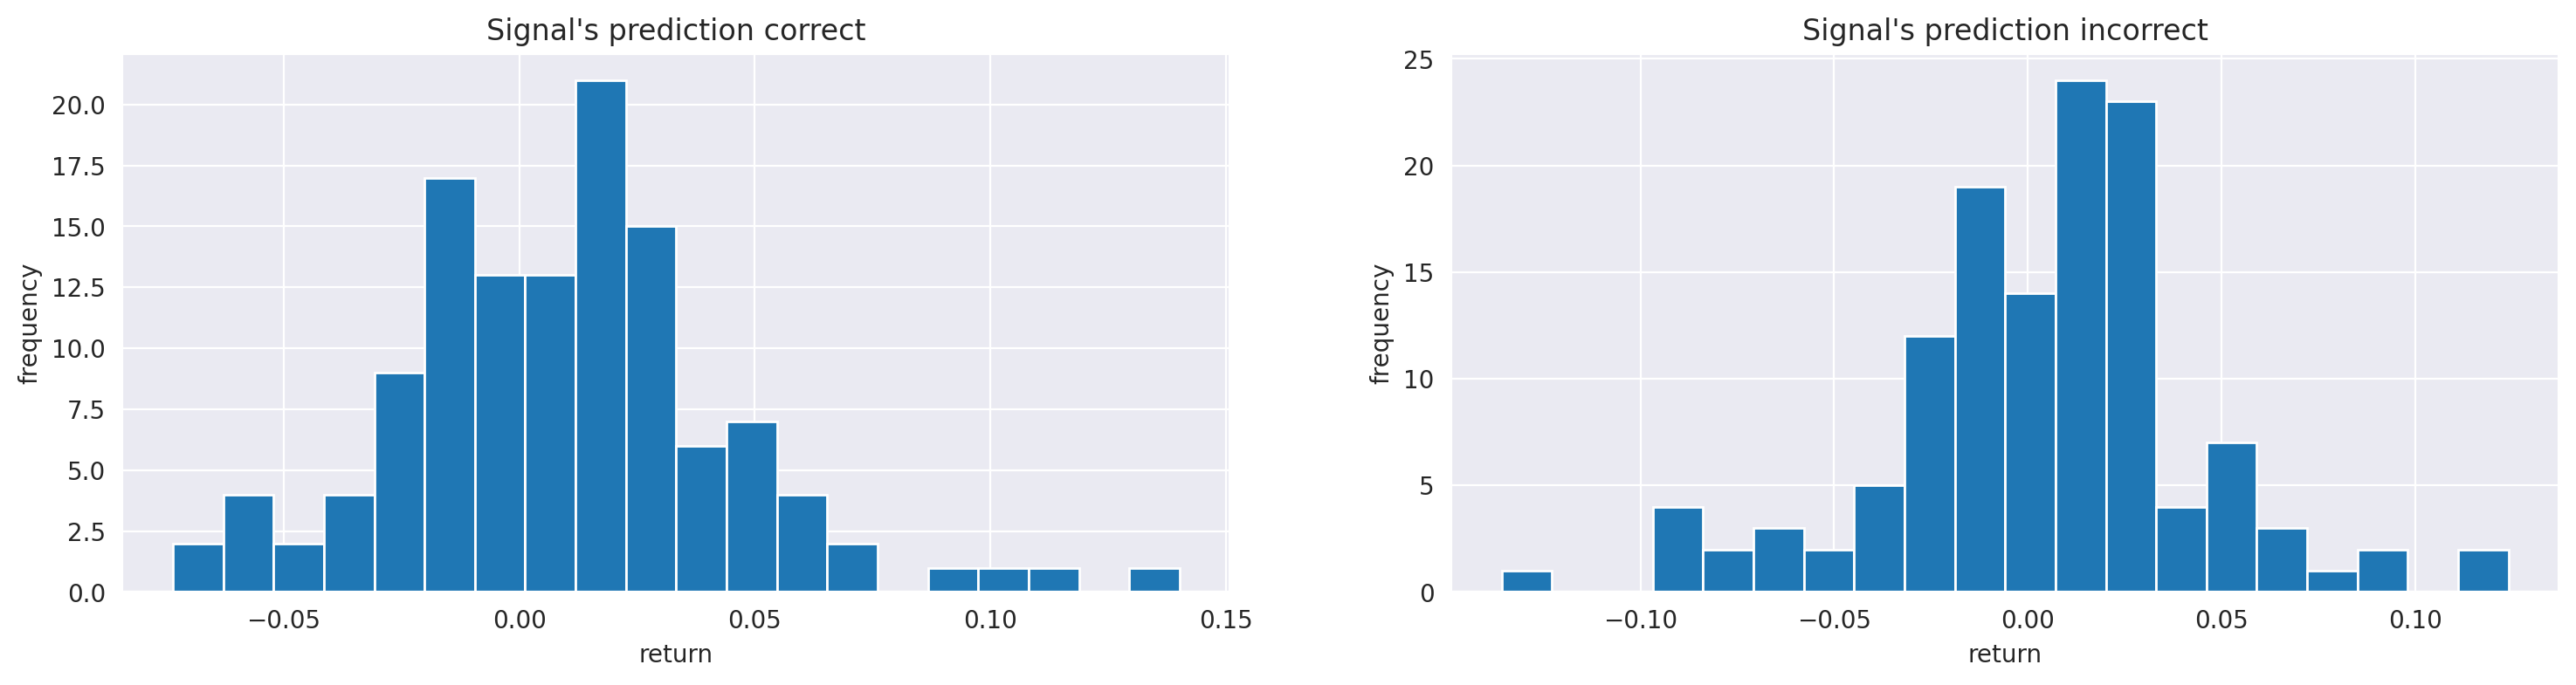

In [41]:
fig,axs = plt.subplots(1,2,figsize=(18,4))
axs[0].hist(ret_signal_correct, bins=20)
axs[0].set_title('Signal\'s prediction correct')
axs[0].set_xlabel('return')
axs[0].set_ylabel('frequency')
axs[1].hist(ret_signal_incorrect, bins=20)
axs[1].set_title('Signal\'s prediction incorrect')
axs[1].set_xlabel('return')
axs[1].set_ylabel('frequency')

In [43]:
from scipy.stats import kstest
kstest(ret_signal_correct.values, ret_signal_incorrect.values)

KstestResult(statistic=0.08085619918699187, pvalue=0.7640687915139467, statistic_location=-0.022337797177498397, statistic_sign=-1)

It looks like the signal is just random, but then why the strategy is profitable? Let's see how it compares with random trading.

In [44]:
random_signal_metrics = pd.DataFrame(columns=['Total return', 'APR', 'Sharpe', 'MaxDD', 'MaxDDD'])

for i in tqdm(range(1000)):
    np.random.seed(i)
    signal = np.random.choice([-1,1], size=252)
    positions = pd.DataFrame(index=returns_m.index, columns=returns_m.columns)
    positions[s1] = (signal>0).astype(int)
    positions[s2] = (signal<0).astype(int)
    algo_ret = (positions.shift() * returns_m).sum(axis=1)
    algo_cumret = (1 + algo_ret).cumprod()
    algo_cumret /= algo_cumret[0]

    random_signal_metrics.loc[i] = calculate_metrics(algo_cumret)

100%|██████████| 1000/1000 [00:05<00:00, 194.13it/s]


In [45]:
random_signal_metrics.describe()

,Total return,APR,Sharpe,MaxDD,MaxDDD
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,3.640432,0.070345,0.554282,-0.361422,50.137000
std,2.303307,0.024199,0.161709,0.070127,25.274236
min,0.162484,0.007195,0.121895,-0.589998,23.000000
25%,1.995739,0.053636,0.442332,-0.408467,33.000000
50%,3.089002,0.069362,0.544445,-0.362710,44.000000
75%,4.840629,0.087672,0.669746,-0.310476,58.250000
max,15.245519,0.141968,1.026688,-0.162061,194.000000


In [46]:
results_df.loc[['Algo']]

,Total return,APR,Sharpe,MaxDD,MaxDDD
Algo,3.612102,0.075509,0.62066,-0.441542,29.0


In [47]:
for metric in random_signal_metrics.columns[:-1]:
    backtest_val = results_df.loc['Algo'][metric] # value of the metric in backtest
    num_outperf = random_signal_metrics[random_signal_metrics[metric]>=backtest_val].shape[0]
    print(f'{metric} : {num_outperf / len(random_signal_metrics)}')

# MaxDDD must be LOWER than in backtest
metric = 'MaxDDD'
backtest_val = results_df.loc['Algo'][metric]
num_outperf = random_signal_metrics[random_signal_metrics[metric]<=backtest_val].shape[0]
print(f'{metric} : {num_outperf / len(random_signal_metrics)}')

Total return : 0.406
APR : 0.406
Sharpe : 0.346
MaxDD : 0.874
MaxDDD : 0.199


In [48]:
random_signal_metrics[(random_signal_metrics['Total return']>=results_df.loc['Algo']['Total return']) & 
                    (random_signal_metrics['APR']>=results_df.loc['Algo']['APR']) & 
                    (random_signal_metrics['Sharpe']>=results_df.loc['Algo']['Sharpe']) & 
                    (random_signal_metrics['MaxDD']>=results_df.loc['Algo']['MaxDD']) & 
                    (random_signal_metrics['MaxDDD']<=results_df.loc['Algo']['MaxDDD'])].shape[0] / len(random_signal_metrics)

0.14